In [9]:
%pip install pandas scikit-learn matplotlib numpy xgboost
import sys
import os
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost

Note: you may need to restart the kernel to use updated packages.


split data into train and test sets

remove certain columns because they are not needed for this first data exploration && club position type ~ club avg position, do not need to double count

In [10]:
from sklearn.model_selection import train_test_split

player_transfer_data = pd.read_csv('data/final_data/club_player_transfer_stats.csv')

player_transfer_data.drop(columns=['season', 'club_leaving', 'club_joining', 'player_name'], inplace=True)


train_set, test_set = train_test_split(player_transfer_data, test_size=0.2, random_state=42)
print(f"data size={len(player_transfer_data)}; training size={len(train_set)}; testing size={len(test_set)}")
train_set.head()

data size=935; training size=748; testing size=187


,age,position,transfer_period,adjusted_fee,minutes_played_leaving,goals_leaving,assists_leaving,cards_leaving,minutes_played_joining,avg_attendance_leaving,club_avg_position_leaving,club_position_type_leaving,avg_attendance_joining,club_avg_position_joining,club_position_type_joining
408,28,Midfielder,Winter,3.31695,0.222807,1.0,0.0,2.0,0.178363,0.880269,15,relegation,0.566271,11,mid
5,28,Forward,Summer,5.10435,0.143275,1.0,1.0,0.0,0.954581,0.710706,4,top,0.804400,10,mid
54,22,Midfielder,Summer,4.02975,0.918713,3.0,4.0,3.0,0.951901,0.955938,20,relegation,0.764956,7,top
275,19,Midfielder,Winter,2.40990,0.001754,0.0,0.0,0.0,0.167251,0.663371,16,relegation,0.870372,9,mid
868,31,Midfielder,Summer,1.32341,0.804581,1.0,5.0,21.0,0.056287,0.825922,13,mid,0.822054,15,relegation


In [11]:

features = train_set.drop(columns=['minutes_played_joining'])
target = train_set['minutes_played_joining']
features.head()


,age,position,transfer_period,adjusted_fee,minutes_played_leaving,goals_leaving,assists_leaving,cards_leaving,avg_attendance_leaving,club_avg_position_leaving,club_position_type_leaving,avg_attendance_joining,club_avg_position_joining,club_position_type_joining
408,28,Midfielder,Winter,3.31695,0.222807,1.0,0.0,2.0,0.880269,15,relegation,0.566271,11,mid
5,28,Forward,Summer,5.10435,0.143275,1.0,1.0,0.0,0.710706,4,top,0.804400,10,mid
54,22,Midfielder,Summer,4.02975,0.918713,3.0,4.0,3.0,0.955938,20,relegation,0.764956,7,top
275,19,Midfielder,Winter,2.40990,0.001754,0.0,0.0,0.0,0.663371,16,relegation,0.870372,9,mid
868,31,Midfielder,Summer,1.32341,0.804581,1.0,5.0,21.0,0.825922,13,mid,0.822054,15,relegation


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

categorical_col_names = ['position', 'transfer_period', 'club_position_type_leaving', 'club_position_type_joining']
categorical = features[categorical_col_names]
categorical_pipeline = Pipeline([
    ("one_hot_encoder", OneHotEncoder()),
    ])

numerical_col_names = [c for c in features.columns if c not in categorical_col_names]
numerical = features[numerical_col_names]
numerical_pipeline = Pipeline([
    # ('median_imputer', SimpleImputer(strategy='median')),
    ('numerical', StandardScaler()),
    ])

feature_transformer = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_col_names),
    ('numerical', numerical_pipeline, numerical_col_names)
    ])

features_prepped = feature_transformer.fit_transform(features)
pd.DataFrame(features_prepped)



,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.555134,-0.537279,-1.023019,-0.526098,-0.727544,-0.657248,0.760332,1.071881,-2.113656,0.033051
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.555134,-0.418723,-1.326353,-0.526098,-0.592540,-0.851834,-0.824405,-1.589386,0.040719,-0.214170
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-1.167855,-0.490000,1.631151,-0.392769,-0.187526,-0.559955,1.467536,2.281548,-0.316135,-0.955831
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-2.029350,-0.597442,-1.866108,-0.592763,-0.727544,-0.851834,-1.266804,1.313815,0.637578,-0.461390
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.416629,-0.669507,1.195853,-0.526098,-0.052522,1.191319,0.252405,0.588015,0.200436,1.021933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.129464,-0.688980,1.291574,-0.259440,0.352492,-0.365369,1.326723,2.281548,0.825795,-0.214170
744,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-1.167855,-0.245783,-1.337504,-0.592763,-0.592540,-0.462662,-0.824405,-1.589386,0.211380,1.021933
745,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,-0.880690,0.135042,-1.414081,-0.392769,-0.727544,-0.657248,1.382433,0.829948,-1.439786,1.269153
746,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,-1.167855,-0.192626,0.543834,-0.259440,-0.322531,-0.559955,0.051255,-0.137786,0.220381,0.527492


In [17]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold

x_train, x_test, y_train, y_test = train_test_split(features_prepped, target, test_size=0.2, random_state=42)

# params = {
#     'max_depth': [x for x in range(3, 11)],
#     'n_estimators': [x for x in range(0, 1000, 100)],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [1, 1.5, 2]
# }

# grid_search = GridSearchCV(XGBRegressor(objective='reg:squarederror'), params, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
# grid_search.fit(x_train, y_train)
# print("Mean Squared Errors for each parameter combination:", grid_search.cv_results_['mean_test_score'])

# print('best params:', grid_search.best_params_)

# best_model = grid_search.best_estimator_

bst = XGBRegressor(n_estimators=300, max_depth=3, learning_rate=0.01, objective='reg:squarederror', reg_alpha=0.1, reg_lambda=2)
bst.fit(x_train, y_train)
y_pred = bst.predict(x_test)
preds = bst.predict(x_test)

# preds = best_model.predict(x_test)
preds = bst.predict(x_test)

mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

r_squared = r2_score(y_test, preds)
print("R-squared:", r_squared)


RMSE: 0.20790402521374138
R-squared: 0.14792293282212188


In [18]:
# determined using GridSearchCV

# Mean Squared Errors for each parameter combination: [-0.05740648 -0.05740648 -0.05740648 ... -0.05647918 -0.05743185
#  -0.057684  ]
# best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 2}
# RMSE: 0.20790402521374138
# R-squared: 0.14792293282212188


In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_prepped, target, test_size=0.2, random_state=42)
regr = MLPRegressor(random_state=42, max_iter=500, learning_rate='adaptive').fit(X_train, y_train)
predictions = regr.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

r_squared = regr.score(X_test, y_test)
print("R-squared:", r_squared)


RMSE: 0.22242640544600747
R-squared: 0.02472797222612111


In [23]:
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(features_prepped, target, test_size=0.2, random_state=42)
regr = svm.SVR()
regr.fit(X_train, y_train)
predictions = regr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

r_squared = regr.score(X_test, y_test)
print("R-squared:", r_squared)



RMSE: 0.22886335143311848
R-squared: -0.032536916683340245


Note: you may need to restart the kernel to use updated packages.


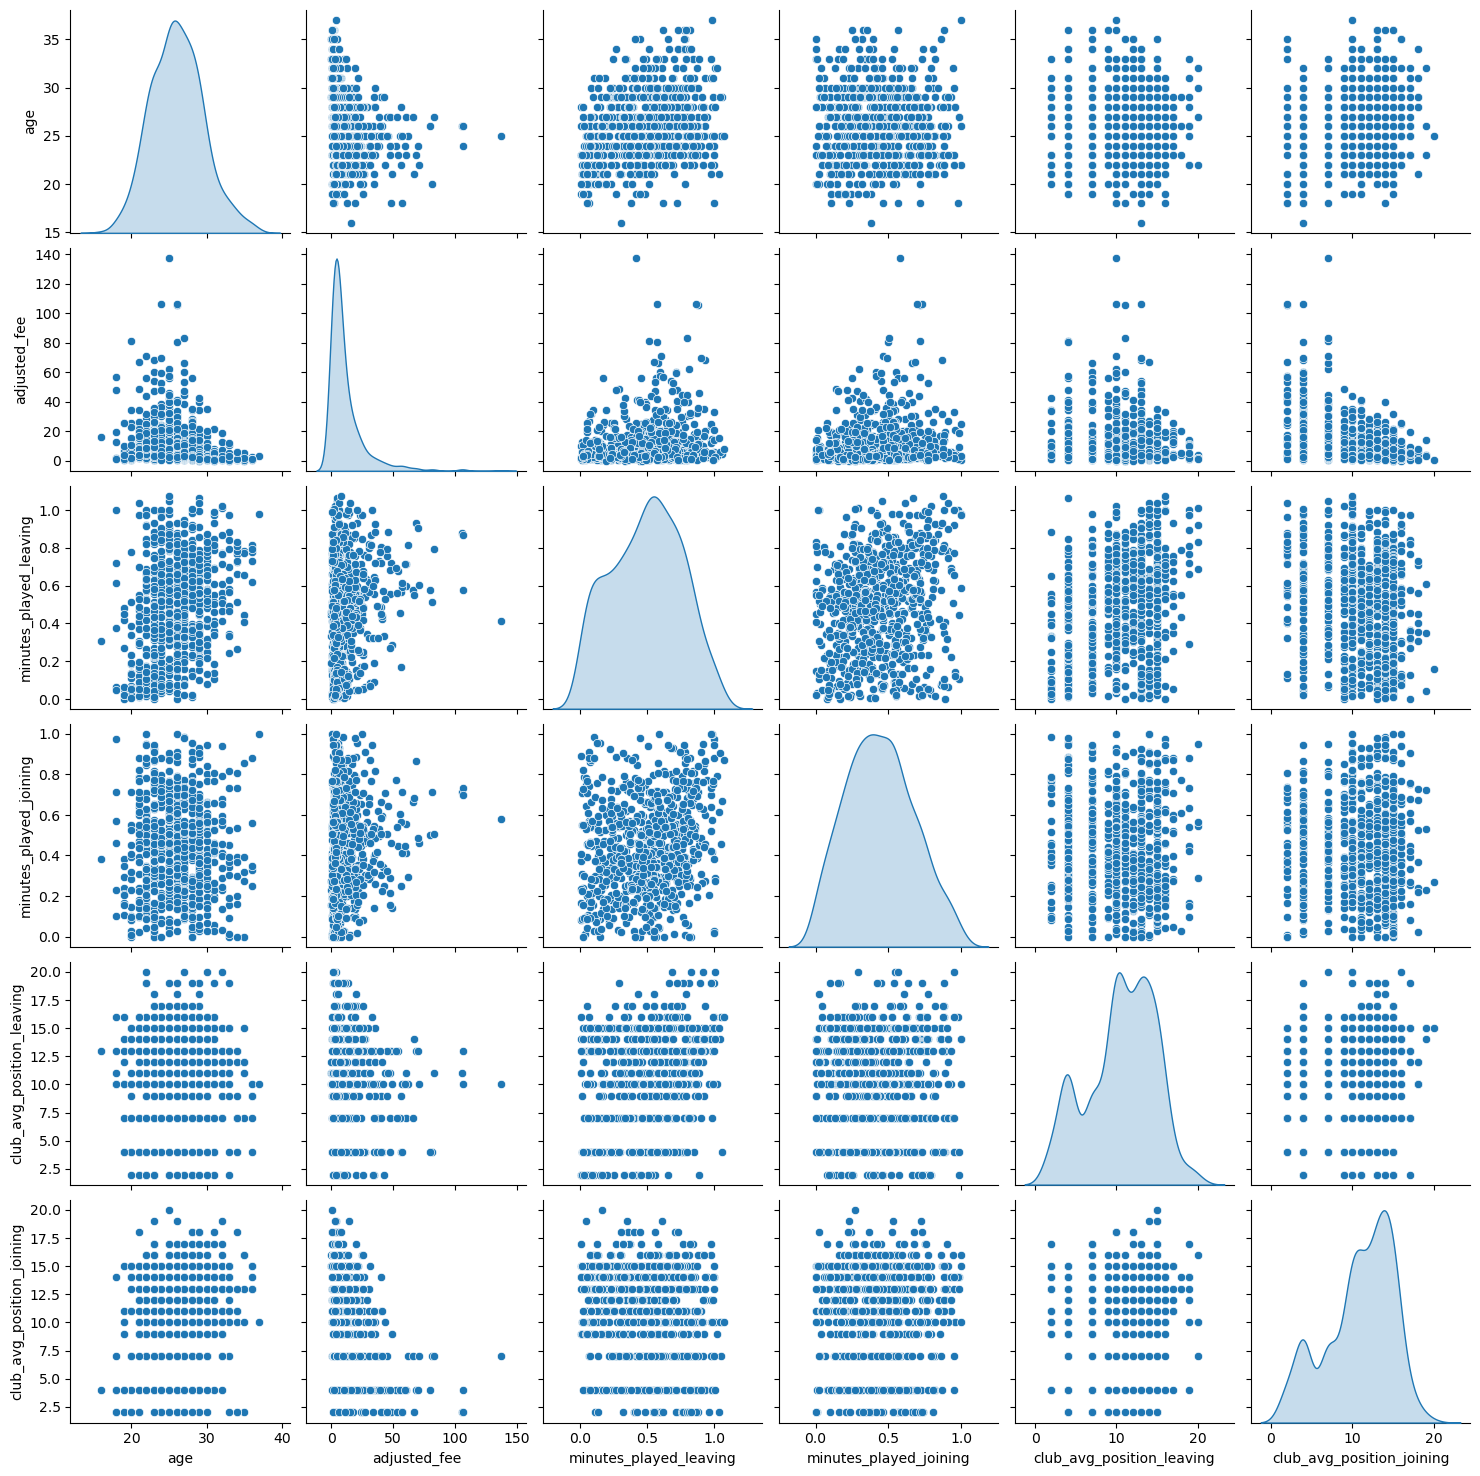

In [26]:
%pip install -q seaborn
import seaborn as sns

player_transfer_data
train_set

pairplot_fig = sns.pairplot(train_set[['age', 'adjusted_fee', 'minutes_played_leaving', 'minutes_played_joining', 'club_avg_position_leaving', 'club_avg_position_joining']], diag_kind='kde', markers=["o", "s", "D"])

pairplot_fig.savefig('visualizations/pairplot_output.png')


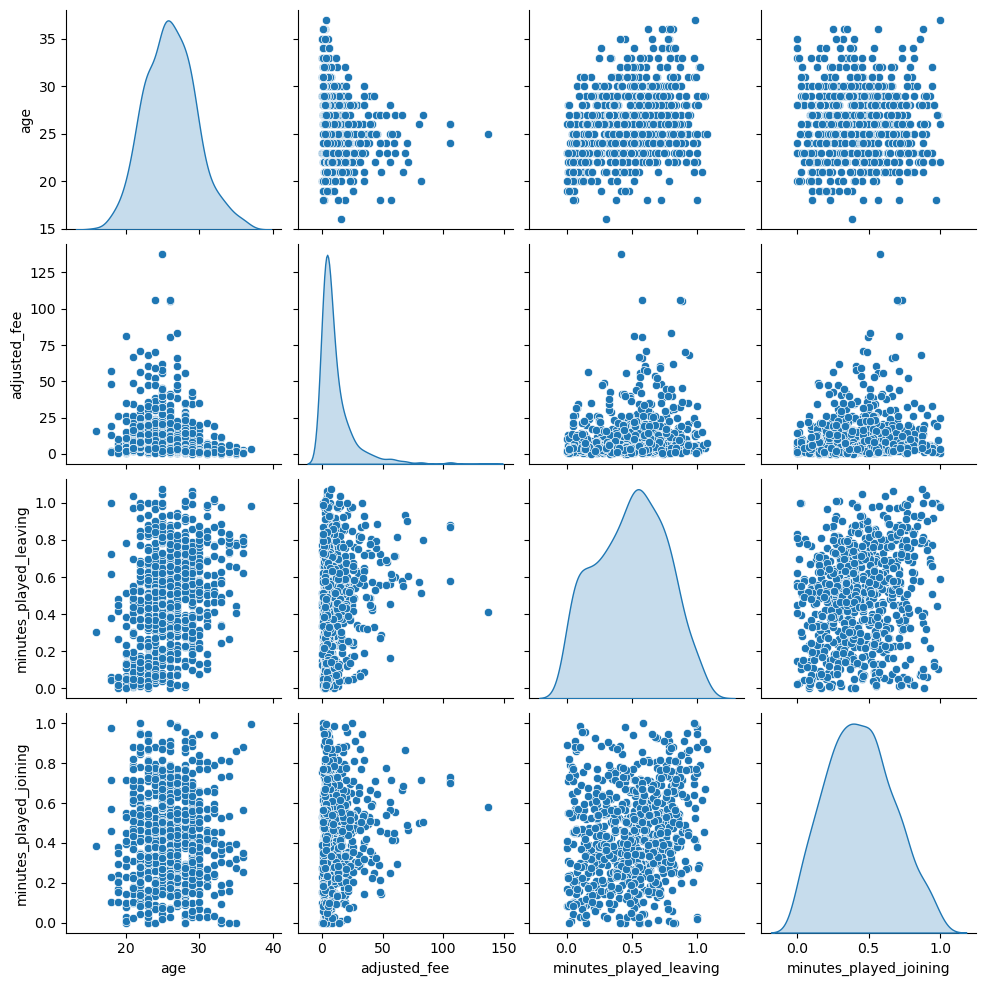

In [27]:
pairplot_fig = sns.pairplot(train_set[['age', 'adjusted_fee', 'minutes_played_leaving', 'minutes_played_joining']], diag_kind='kde', markers=["o", "s", "D"])

pairplot_fig.savefig('visualizations/pairplot_output2.png')